# Importation des packages

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

Utilisation de ce guide: https://www.kaggle.com/code/sbongo/for-beginners-tackling-toxic-using-keras

In [11]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data[list_classes].values
list_sentences_train = data["comment_text"]

# Préparation des données

In [26]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

In [27]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [30]:
# Adding padding in case sentences aren't the same length
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [31]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

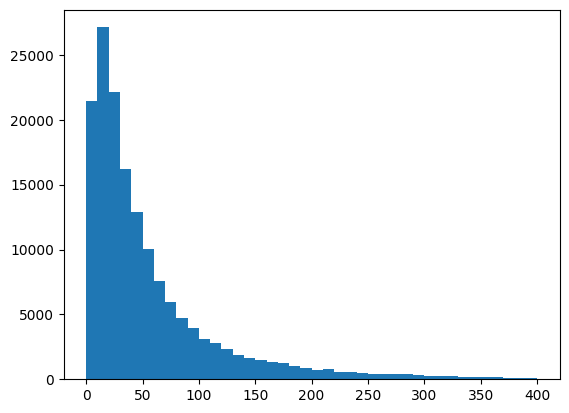

In [32]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [42]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [43]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# Création du modèle

In [44]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [45]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Entraînement du modèle baseline

In [47]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 420s 93ms/step - loss: 0.0679 - accuracy: 0.9618 - val_loss: 0.0487 - val_accuracy: 0.9934
Epoch 2/2
4488/4488 [==============================] - 411s 92ms/step - loss: 0.0451 - accuracy: 0.9915 - val_loss: 0.0476 - val_accuracy: 0.9937


# Itération de la modélisation

In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 60)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                           

In [49]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 200, 60)

In [50]:
print (layer_output)

[[[ 0.00184678 -0.17355718 -0.03616454 ... -0.24159765  0.02263298
    0.0979557 ]
  [ 0.00460814 -0.194629   -0.02805811 ... -0.24786076  0.01307158
    0.09597939]
  [ 0.00665633 -0.19394289 -0.02454557 ... -0.23954093  0.009184
    0.09621713]
  ...
  [-0.1567759   0.35732472 -0.02725708 ... -0.06115461  0.05513069
   -0.2596013 ]
  [-0.13977307  0.64324695  0.05050573 ... -0.00521301  0.13745967
   -0.28346708]
  [-0.15233415  0.19068168  0.03017092 ... -0.03951456  0.02896583
   -0.16830479]]]
